In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Agar display() berfungsi di Jupyter
from IPython.display import display

# --- Impor Fungsi dari File .py Eksternal ---
from clustering import perform_clustering, plot_clusters # <--- IMPOR BARU DARI clustering.py



In [2]:
# Fungsi Preprocessing
def load_data(filepath):
    """
    Memuat dataset dari file Excel.
    Menampilkan pesan error jika file tidak ditemukan atau ada masalah lain.
    """
    try:
        df = pd.read_excel(filepath)
        print(f"✔️ Data '{filepath}' berhasil dimuat.")
        return df
    except FileNotFoundError:
        print(f"❌ Error: File '{filepath}' tidak ditemukan. Pastikan file Excel berada di direktori yang sama.")
        return None
    except Exception as e:
        print(f"❌ Error saat memuat data dari '{filepath}': {e}")
        return None

def preprocess_data(df):
    """
    Melakukan pra-pemrosesan data: penanganan nama kolom, konversi tipe data,
    penanganan missing values, encoding kategorikal, dan scaling fitur numerik.
    Mengembalikan DataFrame yang sudah diproses dan objek StandardScaler yang sudah dilatih.
    """
    df_processed = df.copy()

    print("\n--- Tahap Preprocessing ---")

    # Penanganan Nama Kolom: Ubah ke lowercase, ganti spasi dengan underscore
    df_processed.columns = df_processed.columns.str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.lower()
    print("  - Nama kolom telah dibersihkan dan diubah ke huruf kecil.")

    # Penanganan Kolom 'harga': Konversi ke numerik jika formatnya masih teks
    if 'harga' in df_processed.columns:
        df_processed['harga'] = df_processed['harga'].astype(str).str.replace('rp.', '', regex=False).str.replace('.', '', regex=False).astype(float)
        print("  - Kolom 'harga' telah dikonversi ke format numerik.")
    else:
        print("  ⚠️ Peringatan: Kolom 'harga' tidak ditemukan. Pastikan nama kolom target Anda benar.")

    # Penanganan Missing Values: Isi numerik dengan median, kategorikal dengan mode
    for col in df_processed.select_dtypes(include=np.number).columns:
        if df_processed[col].isnull().sum() > 0:
            df_processed[col] = df_processed[col].fillna(df_processed[col].median())
            print(f"  - Mengisi missing values di kolom numerik '{col}' dengan median.")

    # Mengisi missing values untuk kolom bertipe 'object' (string) dengan mode
    for col in df_processed.select_dtypes(include='object').columns:
        if df_processed[col].isnull().sum() > 0:
            df_processed[col] = df_processed[col].fillna(df_processed[col].mode()[0])
            print(f"  - Mengisi missing values di kolom kategorikal '{col}' dengan mode.")

    # Encoding Semua Kolom Kategorikal (tipe 'object')
    categorical_cols_to_encode = df_processed.select_dtypes(include='object').columns.tolist()

    if 'harga' in categorical_cols_to_encode:
        categorical_cols_to_encode.remove('harga')

    if categorical_cols_to_encode:
        print("  - Melakukan Label Encoding pada kolom-kolom kategorikal berikut:")
        for col in categorical_cols_to_encode:
            le = LabelEncoder()
            df_processed[col] = le.fit_transform(df_processed[col].astype(str))
            print(f"    - Kolom '{col}'")
    else:
        print("  - Tidak ditemukan kolom kategorikal (tipe object) untuk di-encode.")

    # Scaling Fitur Numerik (Kecuali target 'harga')
    numeric_features_to_scale = df_processed.select_dtypes(include=np.number).columns.tolist()
    if 'harga' in numeric_features_to_scale:
        numeric_features_to_scale.remove('harga')

    scaler = StandardScaler()
    if numeric_features_to_scale:
        df_processed[numeric_features_to_scale] = scaler.fit_transform(df_processed[numeric_features_to_scale])
        print(f"  - Melakukan StandardScaler pada fitur: {', '.join(numeric_features_to_scale)}.")
    else:
        print("  ⚠️ Peringatan: Tidak ada fitur numerik yang tersisa untuk diskala setelah mengecualikan 'harga'.")

    print("--- Preprocessing Selesai ---")
    return df_processed, scaler


In [3]:
# Fungsi untuk modeling
def train_regression_model(df, test_size=0.2, random_state=42):
    """
    Melatih model regresi (RandomForestRegressor) untuk memprediksi harga rumah.
    Mengembalikan model yang dilatih, data uji, prediksi, dan metrik evaluasi.
    """
    print("\n--- Tahap Training Model Regresi ---")
    if 'harga' not in df.columns:
        print("❌ Error: Kolom 'harga' (target) tidak ditemukan di DataFrame. Tidak bisa melatih model.")
        return None, None, None, None, None

    X = df.drop(columns=['harga'])
    y = df['harga']

    if X.empty:
        print("❌ Error: Tidak ada fitur yang tersisa untuk melatih model setelah menghapus kolom target.")
        return None, None, None, None, None

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    print(f"  - Data dibagi: {len(X_train)} data latih, {len(X_test)} data uji (test_size={test_size*100}%).")

    model = RandomForestRegressor(n_estimators=100, random_state=random_state, n_jobs=-1)
    model.fit(X_train, y_train)
    print("  ✔️ Model RandomForestRegressor berhasil dilatih.")

    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    metrics = {'r2': r2, 'mae': mae, 'mse': mse, 'rmse': rmse}
    print("--- Training Model Regresi Selesai ---")
    return model, X_test, y_test, y_pred, metrics

def make_regression_prediction(model, new_data_df_scaled):
    """
    Membuat prediksi harga rumah menggunakan model yang sudah dilatih.
    Diasumsikan new_data_df_scaled sudah dalam format dan skala yang benar.
    """
    if model:
        try:
            prediction = model.predict(new_data_df_scaled)
            print(f"  ✔️ Prediksi berhasil dilakukan.")
            return prediction
        except Exception as e:
            print(f"  ❌ Error saat membuat prediksi: {e}. Pastikan format dan skala input sesuai.")
            return None
    print("  ⚠️ Peringatan: Model belum dilatih untuk membuat prediksi.")
    return None

In [4]:
# Fungsi Utilitas
def plot_feature_importance(model, feature_names):
    """Membuat bar plot untuk feature importance dari model berbasis tree."""
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

        fig, ax = plt.subplots(figsize=(12, 7))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df, ax=ax)
        ax.set_title('Feature Importance')
        ax.set_xlabel('Importance')
        ax.set_ylabel('Feature')
        plt.tight_layout()
        plt.show() # Tampilkan plot di Jupyter
    else:
        print("  ⚠️ Peringatan: Model yang diberikan tidak memiliki atribut 'feature_importances_'. Visualisasi ini hanya untuk model berbasis tree.")
        return None

def plot_residuals(y_test, y_pred):
    """Membuat scatter plot untuk residual (aktual vs prediksi)."""
    residuals = y_test - y_pred
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.scatterplot(x=y_pred, y=residuals, ax=ax, alpha=0.6)
    ax.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax.set_title('Residual Plot (Aktual vs Prediksi)')
    ax.set_xlabel('Nilai Prediksi')
    ax.set_ylabel('Residual (Aktual - Prediksi)')
    plt.tight_layout()
    plt.show() # Tampilkan plot di Jupyter

In [5]:
# Pemuatan Data
print("--- Memulai Pemuatan Data ---")
df = load_data('data_rumah.xlsx')

if df is None:
    print("❌ Penghentian eksekusi karena data gagal dimuat. Mohon periksa kembali file.")
else:
    print("\nData mentah (5 baris pertama):")
    display(df.head()) # Menggunakan display untuk tampilan DataFrame yang lebih baik

    # ---

    ### 3.2 Pra-pemrosesan Data

    print("\n--- Memulai Pra-pemrosesan Data ---")
    # Pastikan df_processed dan data_scaler dihasilkan di sini
    df_processed, data_scaler = preprocess_data(df.copy())

    print("\nData setelah pra-pemrosesan (5 baris pertama):")
    display(df_processed.head())
    print("\nStatistik deskriptif data setelah diproses:")
    display(df_processed.describe())

--- Memulai Pemuatan Data ---
✔️ Data 'data_rumah.xlsx' berhasil dimuat.

Data mentah (5 baris pertama):


,HARGA,Luas Tanah M2,Luas Bangunan M2,JKT,JKM,GRS,Tahun Bangun,Kondisi
0,28000000000,1100,700,5,6,1.0,2021,Baru
1,19000000000,824,800,4,4,1.0,2008,Butuh Renovasi
2,4700000000,500,400,4,3,1.0,1995,Butuh Renovasi
3,4900000000,251,300,5,4,1.0,2017,Bagus
4,28000000000,1340,575,4,5,1.0,2006,Baru



--- Memulai Pra-pemrosesan Data ---

--- Tahap Preprocessing ---
  - Nama kolom telah dibersihkan dan diubah ke huruf kecil.
  - Kolom 'harga' telah dikonversi ke format numerik.
  - Mengisi missing values di kolom numerik 'grs' dengan median.
  - Melakukan Label Encoding pada kolom-kolom kategorikal berikut:
    - Kolom 'kondisi'
  - Melakukan StandardScaler pada fitur: luas_tanah_m2, luas_bangunan_m2, jkt, jkm, grs, tahun_bangun, kondisi.
--- Preprocessing Selesai ---

Data setelah pra-pemrosesan (5 baris pertama):


,harga,luas_tanah_m2,luas_bangunan_m2,jkt,jkm,grs,tahun_bangun,kondisi
0,2.800000e+10,1.072891,0.469957,0.270741,1.082862,0.0,1.442477,-0.020686
1,1.900000e+10,0.552926,0.690880,-0.228360,0.031509,0.0,0.143359,1.197344
2,4.700000e+09,-0.057468,-0.192812,-0.228360,-0.494167,0.0,-1.155759,1.197344
3,4.900000e+09,-0.526568,-0.413736,0.270741,0.031509,0.0,1.042749,-1.238716
4,2.800000e+10,1.525035,0.193803,-0.228360,0.557186,0.0,-0.056505,-0.020686



Statistik deskriptif data setelah diproses:


,harga,luas_tanah_m2,luas_bangunan_m2,jkt,jkm,grs,tahun_bangun,kondisi
count,1.001000e+03,1.001000e+03,1.001000e+03,1.001000e+03,1.001000e+03,1001.0,1.001000e+03,1.001000e+03
mean,1.747472e+10,4.968830e-17,3.194248e-17,9.937661e-17,1.135733e-16,0.0,2.196933e-15,1.109114e-16
std,2.079548e+10,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,0.0,1.000500e+00,1.000500e+00
min,4.300000e+08,-9.579884e-01,-9.925543e-01,-1.725661e+00,-1.545521e+00,0.0,-1.655420e+00,-1.238716e+00
25%,6.750000e+09,-5.849697e-01,-4.137355e-01,-2.283597e-01,-4.941675e-01,0.0,-8.559623e-01,-1.238716e+00
50%,1.350000e+10,-2.458617e-01,-1.685108e-01,-2.283597e-01,3.150909e-02,0.0,-5.650509e-02,-2.068583e-02
75%,2.000000e+10,2.759877e-01,2.490341e-01,2.707408e-01,3.150909e-02,0.0,8.428843e-01,1.197344e+00
max,2.500000e+11,1.179247e+01,2.101581e+01,1.125095e+01,1.212207e+01,0.0,1.642342e+00,1.197344e+00



--- Memulai Eksplorasi Data (EDA) ---

Distribusi Harga Rumah:


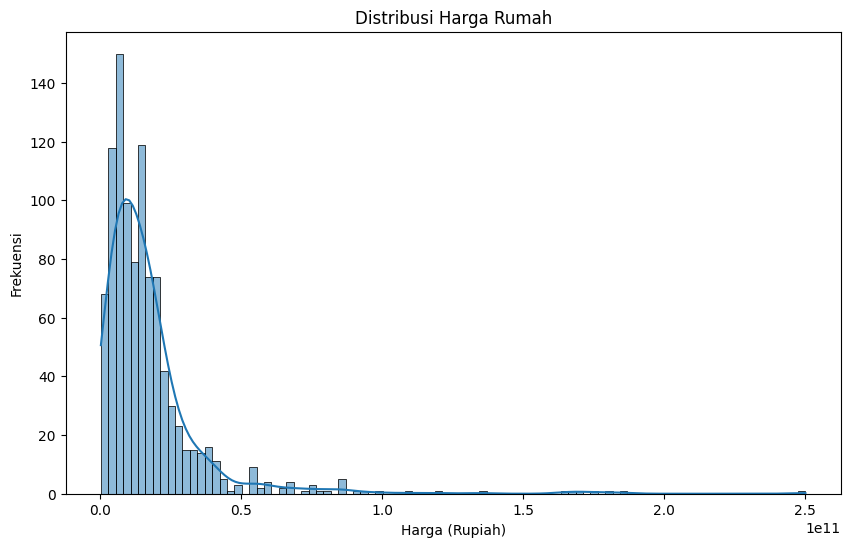


Matriks Korelasi Antar Fitur Numerik:


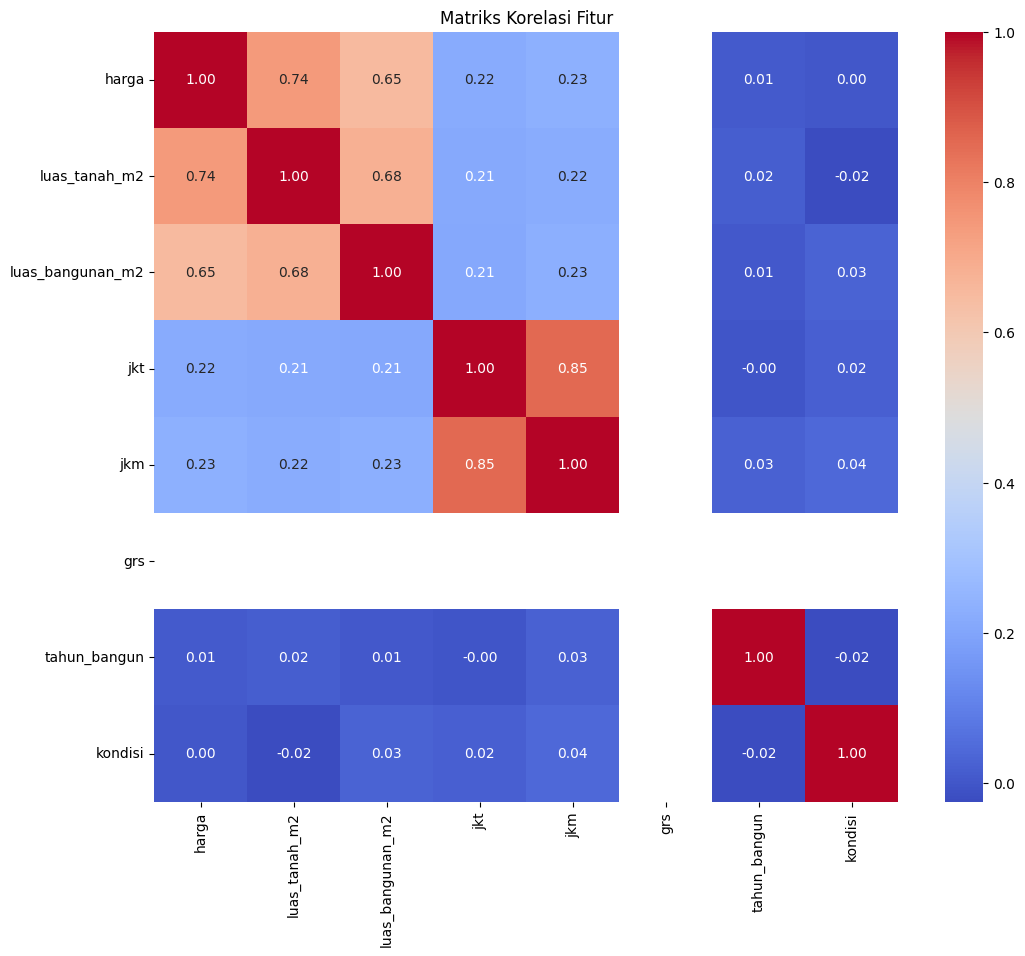

In [6]:
# Eksplorasi data
print("\n--- Memulai Eksplorasi Data (EDA) ---")

print("\nDistribusi Harga Rumah:")
plt.figure(figsize=(10, 6))
sns.histplot(df_processed['harga'], kde=True)
plt.title('Distribusi Harga Rumah')
plt.xlabel('Harga (Rupiah)')
plt.ylabel('Frekuensi')
plt.show()

print("\nMatriks Korelasi Antar Fitur Numerik:")
plt.figure(figsize=(12, 10))
numeric_cols = df_processed.select_dtypes(include=np.number).columns
sns.heatmap(df_processed[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriks Korelasi Fitur')
plt.show()


--- Memulai Modeling Regresi ---

--- Tahap Training Model Regresi ---
  - Data dibagi: 800 data latih, 201 data uji (test_size=20.0%).
  ✔️ Model RandomForestRegressor berhasil dilatih.
--- Training Model Regresi Selesai ---

Metrik Evaluasi Model Regresi:
  R-squared: 0.5069
  MAE (Mean Absolute Error): Rp 4870916069.65
  MSE (Mean Squared Error): Rp 73441042897501003776.00
  RMSE (Root Mean Squared Error): Rp 8569774961.89

Visualisasi Residual Plot:


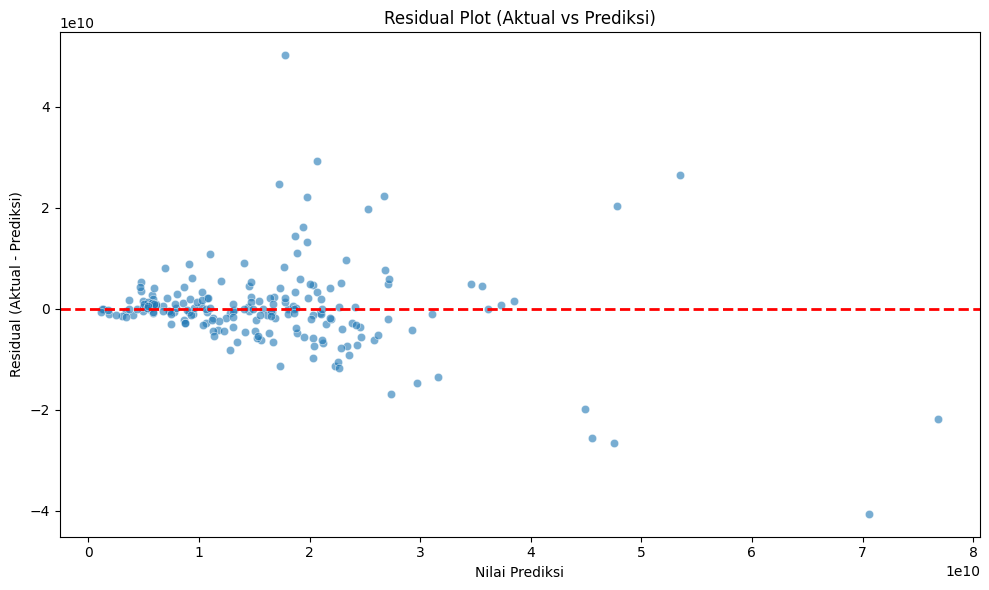


Visualisasi Feature Importance:


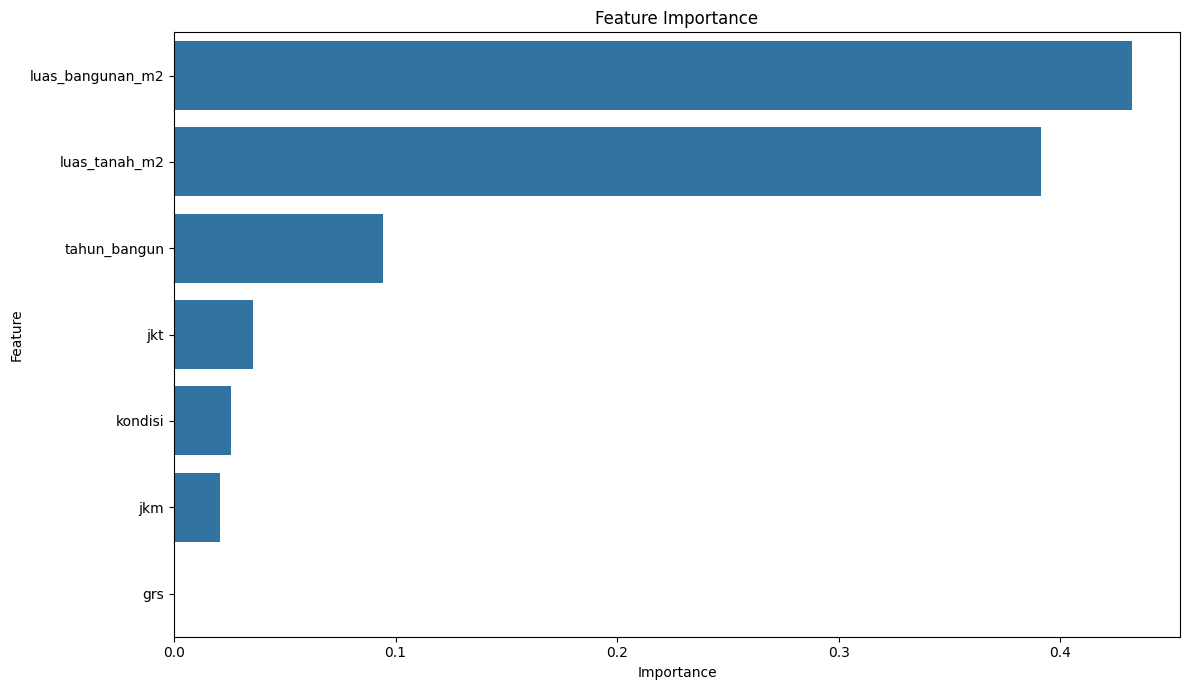

In [7]:
# Modeling untuk regres prediksi harga rumah
print("\n--- Memulai Modeling Regresi ---")

# Parameter untuk model regresi
test_size_reg = 0.2
random_state_reg = 42

# Pastikan df_processed sudah tersedia dari sel sebelumnya
model_reg, X_test_reg, y_test_reg, y_pred_reg, metrics_reg = train_regression_model(df_processed, test_size_reg, random_state_reg)

if model_reg is not None:
    print("\nMetrik Evaluasi Model Regresi:")
    print(f"  R-squared: {metrics_reg['r2']:.4f}")
    print(f"  MAE (Mean Absolute Error): Rp {metrics_reg['mae']:.2f}")
    print(f"  MSE (Mean Squared Error): Rp {metrics_reg['mse']:.2f}")
    print(f"  RMSE (Root Mean Squared Error): Rp {metrics_reg['rmse']:.2f}")

    print("\nVisualisasi Residual Plot:")
    plot_residuals(y_test_reg, y_pred_reg)

    print("\nVisualisasi Feature Importance:")
    plot_feature_importance(model_reg, X_test_reg.columns)


In [9]:
# Contoh Prediksi Harga Rumah Baru

print("\n--- Contoh Prediksi Harga Rumah Baru ---")
print("Masukkan nilai-nilai fitur untuk memprediksi harga rumah baru:")

# Ubah nilai di sini untuk mencoba prediksi dengan data yang berbeda
new_data_input = {
    'luas_tanah_m2': 150,
    'luas_bangunan_m2': 100,
    'jumlah_kamar_tidur': 4,
    'jumlah_kamar_mandi': 3,
    'jumlah_lantai': 2,
    'carport': 1, # 1 untuk 'Ada', 0 untuk 'Tidak Ada' (sesuai encoding di preprocessing)
    'listrik_va': 4400
}

# Buat DataFrame dari input baru
new_data_df_raw = pd.DataFrame([new_data_input])

# Pastikan kolom sesuai dengan yang digunakan saat training (termasuk urutan)
model_features = X_test_reg.columns.tolist()
new_data_aligned = new_data_df_raw.reindex(columns=model_features, fill_value=0)

# Lakukan scaling pada data baru menggunakan scaler yang sudah dilatih
new_data_scaled_array = data_scaler.transform(new_data_aligned)
new_data_scaled_df = pd.DataFrame(new_data_scaled_array, columns=model_features)

print("\nData rumah baru setelah pra-pemrosesan dan scaling:")
display(new_data_scaled_df)

predicted_price = make_regression_prediction(model_reg, new_data_scaled_df)
if predicted_price is not None:
    print(f"Harga prediksi untuk rumah ini adalah: Rp {predicted_price[0]:,.2f}")


--- Contoh Prediksi Harga Rumah Baru ---
Masukkan nilai-nilai fitur untuk memprediksi harga rumah baru:

Data rumah baru setelah pra-pemrosesan dan scaling:


,luas_tanah_m2,luas_bangunan_m2,jkt,jkm,grs,tahun_bangun,kondisi
0,-0.716845,-0.855582,-2.224762,-2.071197,-1.0,-200.520408,-1.238716


  ✔️ Prediksi berhasil dilakukan.
Harga prediksi untuk rumah ini adalah: Rp 4,483,200,000.00



--- Memulai Clustering ---

--- Tahap Clustering K-Means ---
  ✔️ Clustering K-Means dengan k=3 berhasil dilakukan.
--- Clustering Selesai ---

Dataframe dengan label cluster (5 baris pertama):


,luas_tanah_m2,luas_bangunan_m2,jkt,jkm,grs,tahun_bangun,kondisi,cluster
0,1.072891,0.469957,0.270741,1.082862,0.0,1.442477,-0.020686,2
1,0.552926,0.690880,-0.228360,0.031509,0.0,0.143359,1.197344,2
2,-0.057468,-0.192812,-0.228360,-0.494167,0.0,-1.155759,1.197344,1
3,-0.526568,-0.413736,0.270741,0.031509,0.0,1.042749,-1.238716,1
4,1.525035,0.193803,-0.228360,0.557186,0.0,-0.056505,-0.020686,2



Visualisasi Cluster:


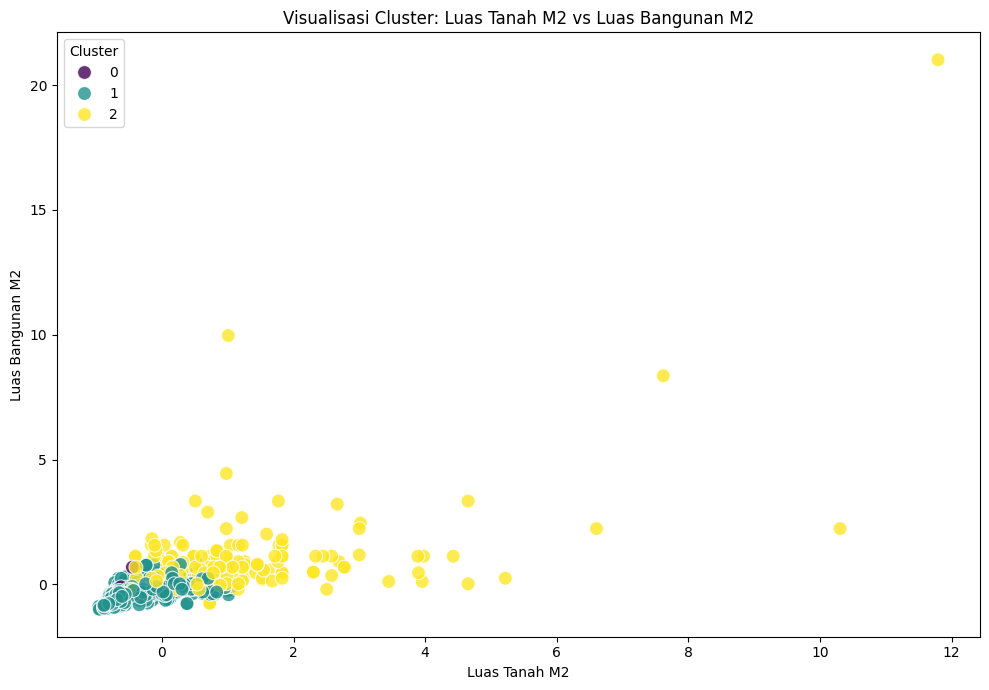


Profil Rata-rata Setiap Cluster:


,luas_tanah_m2,luas_bangunan_m2,jkt,jkm,grs,tahun_bangun,kondisi
cluster,,,,,,,
0,0.106434,0.265235,10.003200,9.318462,0.0,0.209981,0.182319
1,-0.331876,-0.262561,-0.267414,-0.265491,0.0,0.031234,-0.009378
2,1.035666,0.814854,0.587597,0.598629,0.0,-0.102947,0.024801


Tabel di atas menunjukkan rata-rata fitur untuk setiap cluster, membantu memahami karakteristik masing-masing kelompok rumah.

--- Analisis Data Mining Selesai ---


In [10]:
# clustering harga rumah
print("\n--- Memulai Clustering ---")

# Parameter untuk clustering
n_clusters_cluster = 3
random_state_cluster = 42

# Drop 'harga' dan kolom lain yang tidak relevan untuk clustering
features_for_clustering = df_processed.drop(columns=['harga'], errors='ignore')

df_clustered, cluster_labels = perform_clustering(features_for_clustering, n_clusters_cluster, random_state_cluster)

print("\nDataframe dengan label cluster (5 baris pertama):")
display(df_clustered.head())

print("\nVisualisasi Cluster:")
# Sesuaikan fitur yang akan diplot untuk visualisasi cluster
feature_plot_1 = 'luas_tanah_m2' # PASTIKAN MENGGUNAKAN HURUF KECIL DAN GARIS BAWAH
feature_plot_2 = 'luas_bangunan_m2' # PASTIKAN MENGGUNAKAN HURUF KECIL DAN GARIS BAWAH
if feature_plot_1 in df_clustered.columns and feature_plot_2 in df_clustered.columns:
        plot_clusters(df_clustered, feature_plot_1, feature_plot_2)
else:
        print(f"  ⚠️ Peringatan: Fitur '{feature_plot_1}' atau '{feature_plot_2}' tidak ditemukan untuk visualisasi cluster. Mohon cek nama kolom.")

print("\nProfil Rata-rata Setiap Cluster:")
cluster_summary = df_clustered.groupby('cluster').mean(numeric_only=True)
display(cluster_summary)
print("Tabel di atas menunjukkan rata-rata fitur untuk setiap cluster, membantu memahami karakteristik masing-masing kelompok rumah.")

print("\n--- Analisis Data Mining Selesai ---")

In [13]:
df.to_csv("data/data_baru.csv", index=False)